In [1]:
!pip -q install pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Spark DataFrame").getOrCreate()
print("Spark session started")

Spark session started


Βήμα 1ο - Ορισμός συνόλου χαρακτηριστικών (features) και στόχου (label)

In [3]:
#Φορτώνουμε το έτοιμο νέο csv αρχείο από το Θέμα 1 με τις επιπρόσθετες στήλες
from google.colab import files

uploaded = files.upload()
filename = next(iter(uploaded.keys()))
df = spark.read.csv(filename, header=True, inferSchema=True)
print("CSV file loaded into DataFrame")

Saving telecom_new_col.csv to telecom_new_col.csv
CSV file loaded into DataFrame


In [7]:
#Επιλογή features
feature_cols = [
    "AGE", "TENURE_MONTHS", "NUM_COMPLAINTS", "SUPPORT_CALLS",
    "HAS_INTERNET", "HAS_MOBILE", "HAS_TV", "NUM_SERVICES",
    "CONTRACT_TYPE", "PAYMENT_METHOD", "COUNTRY"
]
target_label = "MONTHLY_CHARGES"

#Δημιουργία του model_df για το ML
model_df = df.select(feature_cols + [target_label])

Βήμα 2ο - Προεπεξεργασία & Pipeline

In [8]:
#1ο: StringIndexer: Μετατροπή κατηγορικών πεδίων σε αριθμητικούς δείκτες
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in ["CONTRACT_TYPE", "PAYMENT_METHOD", "COUNTRY"]
]

#2ο: VectorAssembler:Συνδυάστε όλα τα αριθμητικά και κατηγορικά features σε ένα διάνυσμα εισόδου
assembler_inputs = [
    "AGE", "TENURE_MONTHS", "NUM_COMPLAINTS", "SUPPORT_CALLS",
    "HAS_INTERNET", "HAS_MOBILE", "HAS_TV", "NUM_SERVICES",
    "CONTRACT_TYPE_indexed", "PAYMENT_METHOD_indexed", "COUNTRY_indexed"
]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

#3ο: Ορισμός DecisionTreeRegressor
# labelCol="MONTHLY_CHARGES" και featuresCol="features".
dt = DecisionTreeRegressor(labelCol=target_label, featuresCol="features")

#4ο: Δημιουργία του Pipeline
#Ροή:  indexers → (encoder) → assembler → decision tree regressor
pipeline = Pipeline(stages=indexers + [assembler, dt])

print("Το ML Pipeline δημιουργήθηκε επιτυχώς!")

Το ML Pipeline δημιουργήθηκε επιτυχώς!


Βήμα 3ο - Εκπαίδευση

In [12]:
#1ο: Χωρισμός δεδομένων σε train/test (70% / 30%) με σταθερό random seed
train_data, test_data = model_df.randomSplit([0.7, 0.3], seed=42)

#2o: Εκπαίδευση μοντέλου στο training set
model_fit = pipeline.fit(train_data)

#3o: Παραγωγή προβλέψεων στο test set
predictions = model_fit.transform(test_data)

# Εμφάνιση προβλέψεων σε σύγκριση με τις πραγματικές τιμές
print("Δείγμα Προβλέψεων (Πραγματικό vs Πρόβλεψη):")
predictions.select(target_label, "prediction").show(20)

#4o: πολογισμός των μετρικών αξιολόγησης (RMSE και R2)
# Υπολογισμός RMSE (Root Mean Squared Error)
evaluator_rmse = RegressionEvaluator(labelCol=target_label, predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

# Υπολογισμός R2 (Coefficient of Determination)
evaluator_r2 = RegressionEvaluator(labelCol=target_label, predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Δείγμα Προβλέψεων (Πραγματικό vs Πρόβλεψη):
+---------------+------------------+
|MONTHLY_CHARGES|        prediction|
+---------------+------------------+
|          36.44| 39.68572674418604|
|           41.9| 39.68572674418604|
|          35.95|30.020250737463133|
|          40.71| 39.68572674418604|
|          44.76|35.396600985221674|
|          18.04|35.396600985221674|
|          36.73| 39.68572674418604|
|          55.55| 46.69776053215077|
|          39.74| 39.68572674418604|
|          40.73| 51.39729166666669|
|          24.03| 42.88027272727271|
|          40.12| 39.68572674418604|
|          32.16| 39.68572674418604|
|          44.32| 44.78528455284553|
|          19.79|27.334375000000005|
|          47.84| 39.68572674418604|
|          23.77| 44.78528455284553|
|           23.3| 19.98311320754717|
|          32.19| 39.68572674418604|
|          42.76| 46.69776053215077|
+---------------+------------------+
only showing top 20 rows
Root Mean Squared Error (RMSE): 7.93
R-squa

Υπολογισμός μέσου όρου λογαριασμών

In [14]:
from pyspark.sql import functions as F

stats = df.select(F.mean("MONTHLY_CHARGES").alias("avg_charges")).collect()
avg_val = stats[0]["avg_charges"]

print(f"Ο μέσος όρος των λογαριασμών είναι: {avg_val:.2f}€")

Ο μέσος όρος των λογαριασμών είναι: 36.54€


***Σχολιασμός στρατηγικής***

Η τιμή του RMSE (7.93) υποδηλώνει ότι το μοντέλο πέφτει έξω κατά μέσο όρο περίπου 8€ ανά λογαριασμό,ένα σφάλμα που κρίνεται λογικό και «επιχειρησιακά υποφερτό», δεδομένου ότι ο μέσος όρος λογαριασμών είναι 36.54€

Η τιμή του R² (0.49) δείχνει ότι το μοντέλο εξηγεί σχεδόν το ήμισυ (49%) της διακύμανσης των χρεώσεων, συναιπάγοντας ότι τα χαρακτηριστικά (feature_cols) που επιλέξαμε είναι καθοριστικά αλλά όχι τα μοναδικά.

Το μοντέλο είναι «χονδρικά χρήσιμο» για την υποστήριξη της τιμολογιακής πολιτικής και τον σχεδιασμό προσφορών, καθώς μπορεί να προβλέψει με επάρκεια την κατηγορία τιμής στην οποία θα ανήκει ένας πελάτης. Oι προβλέψεις παρέχουν μια αξιόπιστη βάση για σενάρια "what-if" και για την εκτίμηση της αναμενόμενης μηνιαίας χρέωσης βάσει του προφίλ του πελάτη.

Οπτικοποιήσεις Scatter Plot και Feature Importance

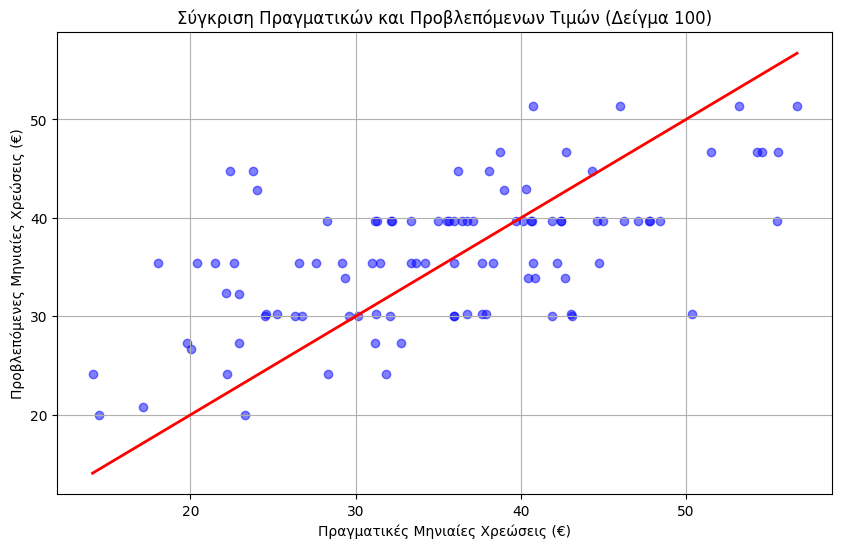

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Μετατρέπουμε ένα δείγμα των προβλέψεων σε Pandas για την οπτικοποίηση
# Παίρνουμε π.χ. 100 γραμμές για να είναι ευανάγνωστο το γράφημα
sample_preds = predictions.select(target_label, "prediction").limit(100).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(sample_preds[target_label], sample_preds["prediction"], color='blue', alpha=0.5)
plt.plot([sample_preds[target_label].min(), sample_preds[target_label].max()],
         [sample_preds[target_label].min(), sample_preds[target_label].max()],
         color='red', lw=2) # Η ιδανική γραμμή όπου Πραγματικό = Πρόβλεψη
plt.xlabel('Πραγματικές Μηνιαίες Χρεώσεις (€)')
plt.ylabel('Προβλεπόμενες Μηνιαίες Χρεώσεις (€)')
plt.title('Σύγκριση Πραγματικών και Προβλεπόμενων Τιμών (Δείγμα 100)')
plt.grid(True)
plt.show()

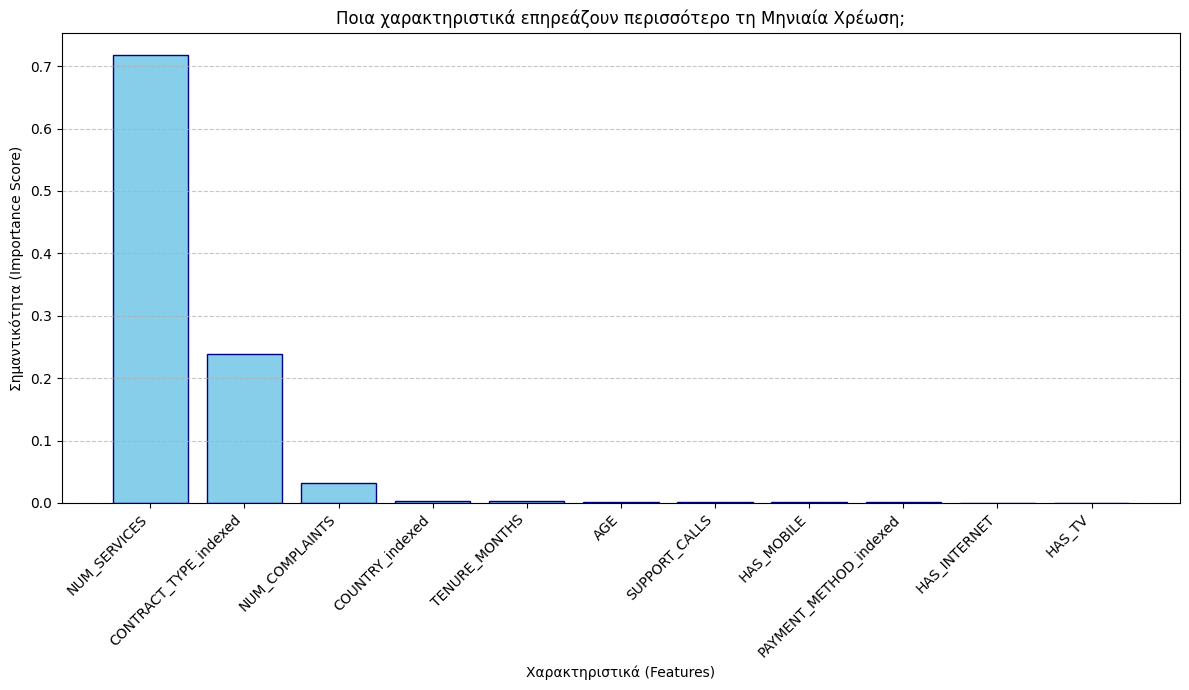

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Παίρνουμε τις τιμές σημαντικότητας από το μοντέλο
importance = model_fit.stages[-1].featureImportances.toArray()
features = assembler_inputs

# 2. Δημιουργία DataFrame και ταξινόμηση
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)

# 3. Δημιουργία Κάθετου Γραφήματος (Vertical Bar Chart)
plt.figure(figsize=(12, 7))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue', edgecolor='navy')

# Προσθήκη ετικετών και τίτλου
plt.ylabel('Σημαντικότητα (Importance Score)')
plt.xlabel('Χαρακτηριστικά (Features)')
plt.title('Ποια χαρακτηριστικά επηρεάζουν περισσότερο τη Μηνιαία Χρέωση;')

# Περιστροφή των ονομάτων των χαρακτηριστικών για να είναι ευανάγνωστα
plt.xticks(rotation=45, ha='right')

# Προσθήκη πλέγματος στον άξονα Y για καλύτερη ανάγνωση των τιμών
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Αυτόματη προσαρμογή ώστε να μην κόβονται οι ετικέτες
plt.tight_layout()

plt.show()